# 1) APOGEE data

* [Create a new data repository for the APOGEE data](#create)
* [Sort and save the field pointings file](#field)
* [Sort and save spectroscopic data](#spectro)
* [Assign photometric data to field files](#photo)

Saved version of the repository online is [here](https://drive.google.com/file/d/1Zw-aspDF3rE1ug6OQb8Sdehq4_BZWR4o/view?usp=sharing)
(This doesn't contain the photometric field files as they were too large to store online)

Run 
```tar -xvf Apogee_new.tar.gz```
to untar and unzip file.

In [3]:
# autoreload modules when files have been altered
%load_ext autoreload
%autoreload 2

import ebf, sys, gc
import numpy as np
import pandas as pd
import dill

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

def ErrorWarning():
    raise ValueError("Wait, don't run this, you don't want to!")

# Create New <a name="create"></a>
New database for information.

In [19]:
from seestar import createNew
createNew.create()
# When requested , give the database a path
# Provide a name for the database 
# (I've used Apogee_new here and for the rest of this notebook but you can change that.)

ZipImportError: bad local file header: /home/andy/anaconda2/lib/python2.7/site-packages/seestar-1.2.7rc0-py2.7.egg

# File Info

In [2]:
from seestar import surveyInfoPickler

In [3]:
# Location of fileinfo file - replace teh fileinfo_path string
fileinfo_path = 'PATH/Apogee_new/Apogee_new_fileinfo.pickle'
fileinfo = surveyInfoPickler.surveyInformation(fileinfo_path)

In [4]:
# Test for any problems in the
fileinfo.testFiles()
# Good to come back to this whenever you move files around or change things.

1) Checking file paths exist:
OK

2) Checking spectroscopic catalogue file structure:
OK

3) Checking field information file structure:
(make sure halfangle is in units of radians.)
OK

4) Checking photometric catalogue file structure:
Checking 4302.csv:
OK

5) Checking selection function pickle paths exist:
The path to your selection function pickled instance, obsSF_pickle_path, does not exist: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/Apogee_new_obsSF.pickle
The path to your selection function pickled instance, obsSF_pickle_path, does not exist: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/Apogee_new_fieldoverlapdatabase
^ These files should exist for an already made selection function. If you're starting from scratch, ignore this!

6) Checking isochrone pickle files exist:
The premade interpolants (isochrone_interpolantinstances.pickle) will be automatically be used to calculate the selection function.


In [10]:
# Some changes will be saved automatically if you run testFiles then save. 
fileinfo.save()

In [7]:
# Joins some of the given folders and filenames together to create full paths
fileinfo()

# Field info <a name="field"></a>

In [1]:
# Field file downloaded from website
filepath = '.../allPlates-l31c.2.fits'

In [4]:
# Generate dataframe from file
from astropy.table import Table

with open(filepath) as data:
    dat = Table.read(data, format='fits')
    
    arr = dat.as_array()
    lstlst = [list(row)[:15]+list(row)[16:] for row in arr.tolist()]
    pointings = pd.DataFrame(lstlst, columns=dat.colnames[:15]+dat.colnames[16:])

In [12]:
# Transform from Equatorial to Galactic (Copied from your CoordTrans script in AngleDisks.EquatToGal)
from seestar import AngleDisks

pointings['RADIUS'] *= np.pi/180

pointings['RA'] = pointings.RACEN * np.pi/180
pointings['Dec'] = pointings.DECCEN * np.pi/180
pointings['glon'], pointings['glat'] = AngleDisks.EquatToGal(pointings.RA, pointings.Dec)

/home/andy/.local/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


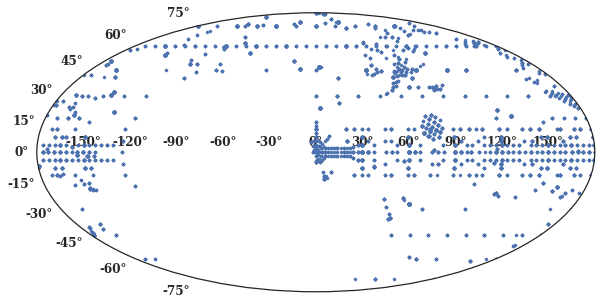

In [13]:
# Scatter of pointings locations
fig = plt.figure(figsize=(10,10))
l = pointings['glon'].copy()
l[l>np.pi] -= 2*np.pi
b = pointings.glat.copy()
plt.subplot(projection='mollweide')
plt.scatter(l, b, s=10)

In [14]:
# Rename columns and provide colour and magnitude boundaries
cols_old = ['LOCATION_ID', 'glon', 'glat', 'RADIUS']
cols_new = ['fieldID', 'glon', 'glat', 'halfangle']
pointings = pointings.rename(index=str, columns=dict(zip(cols_old, cols_new)))
pointings = pointings[cols_new]

pointings['Magmin'] = 'NoLimit'
pointings['Magmax'] = 'NoLimit'
pointings['Colmin'] = 'NoLimit'
pointings['Colmax'] = 'NoLimit'

pointings.drop_duplicates('fieldID', inplace=True)

In [15]:
# Save to csv inside database
pointings.to_csv(fileinfo.field_path, index=False)

<a name="spectro"></a>
# Spectro data

In [44]:
# Spectroscopic datafile which you sent me
filepath = '.../APOGEE_distances_withPRIOR_MASTER_suppapodr14(1).csv'
df = pd.read_csv(filepath)

In [46]:
# Relabel columns and correct units (e.g. log10age --> ageGyr)
cols = ['apogee_id', 'apogee_location_id', 'l', 'b', 's', 
            'apogee_j', 'apogee_h', 'apogee_k', 
            'apogee_m_h', 'dm', 'dist', 'par', 'log10_age',
            'mass', 'Z', 'R', 'phi', 'z',  'flag']
df = df[cols].copy()

cols_old = ['apogee_id', 'apogee_location_id', 'l', 'b', 's', 'dist', 'par', 'log10_age', 'mass', 'Z', 'log10_av', 'R', 'phi', 'z']
cols_new = ['APOGEE_ID', 'fieldID', 'glon', 'glat', 's', 'dist', 'par', 'log10age', 'mass', 'Z', 'log10_av', 'R', 'phi', 'z']
df.rename(index=str, columns=dict(zip(cols_old, cols_new)), inplace=True)

cm_old = ['apogee_j', 'apogee_h', 'apogee_k']
cm_new = ['Japp', 'Kapp', 'Happ']
df.rename(index=str, columns=dict(zip(cm_old, cm_new)), inplace=True)

df['ageGyr'] = 10**df['log10age']
# Zsolar = 0.0152
df['mh'] = df.Z

In [48]:
# Drop nan values for age and distance and only use flag==False
df = df[pd.notnull(df.ageGyr) & pd.notnull(df.s) & (~df.flag)]
# Only take stars which have normal magnitudes (bad values are -10000)
magcon = (df.Japp<-5000)|(df.Kapp<-5000)|(df.Happ<-5000)
df = df[~magcon]

(277371,
 215081,
 224686,
 224686,
 224686,
 222527,
 229285,
 276430,
 276440,
 277370)

In [56]:
# Save to spectro file
df.to_csv(fileinfo.spectro_path, index=False)

<a name="photo"></a>
# Apogee field assignment 
Assigning photometric stars to correct fields

In [3]:
# This is the list of files in which I have the 2MASS data
files = [str(i*10)+"_"+str((i+1)*10) for i in range(24)]
files.extend([str(i*5)+"_"+str((i+1)*5) for i in range(24*2, 30*2)])
files.extend([str(i*10)+"_"+str((i+1)*10) for i in range(30, 36)])
files = ['.../2MASSgalactic/2MASS_'+filen+'.csv.gz' for filen in files]

In [6]:
FieldAssignment.FieldAssignment(fileinfo_path, files, ncores=1)

Checking photometric catalogue file structure:
Checking /media/andy/UUI/Research/SF/SFdata/2MASS/2MASSgalactic/2MASS_90_100.csv.gz:
Column headers are ['RA' 'Dec' 'j' 'h' 'k' 'glon' 'glat'], 
but photo_coords suggests ['glon', 'glat', 'Japp', 'Kapp', 'Happ'], 
please resolve this.

Tests on the files have raised some warnings. Would you like to continue anyway? (y/n)y

Total number of stars 470000000.
Importing 5310850 stars at a time. Iterating 42264 stars at a time.
Field file path for field 4394: /media/andy/37E3-0F91/Research/SF/SFdata/Apogee_new/photometric/4394.csv
Clearing field files...
...done

File: 2MASS_340_350.csv.gz  Complete: 465745510/470000000(99.095%)  Time: 1020.9m  Projected: 17h10m...Saving: 141/141        
Total stars assigned to fields: 34199298.
Dictionary of stars per field in fileinfo.photo_field_starcount.


<seestar.FieldAssignment.FieldAssignment instance at 0x7f7c00665638>